In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U fastai ddgs primp fasttransform --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.19
    Uninstalling fastai-2.7.19:
      Successfully uninstalled fastai-2.7.19


But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "footballer photos"
1. Use DuckDuckGo to search for images of "cricketer photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a footballer and see if it works.

## Step 1: Download images of cricketers and footballers

In [3]:
from ddgs import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=100): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('footballer player', max_images=1)
urls[0]

'http://3.bp.blogspot.com/-DOTa7_SE9KM/USMtrxdkE2I/AAAAAAAAABA/VvgalhjjsbI/s1600/Lionel-Messi-Top-Player.jpg'

...and then download a URL and take a look at it:

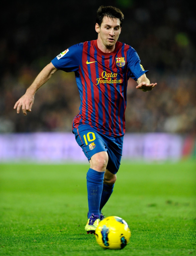

In [5]:
from fastdownload import download_url
dest = 'soccer_player.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "cricketer photos":

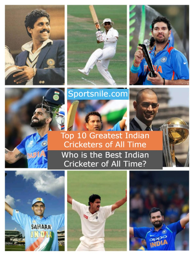

In [6]:
download_url(search_images('famous cricketers', max_images=1)[0], 'c3.jpg')
Image.open('c3.jpg').to_thumb(256, 256)

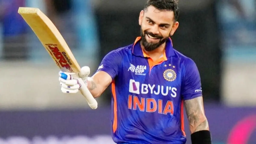

In [7]:
download_url(search_images('cricketer pics', max_images=1)[0], 'cricketer3.jpg', show_progress=False)
Image.open('cricketer3.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [8]:
import shutil
import os

folder_path = "footballer_or_cricketer/cricket"

try:
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' and its contents deleted successfully.")
except OSError as e:
    print(f"Error: {e}")

Error: [Errno 2] No such file or directory: 'footballer_or_cricketer/cricket'


In [9]:
searches = 'footballer','cricketer'
path = Path('footballer_or_cricketer')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}s'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


28

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

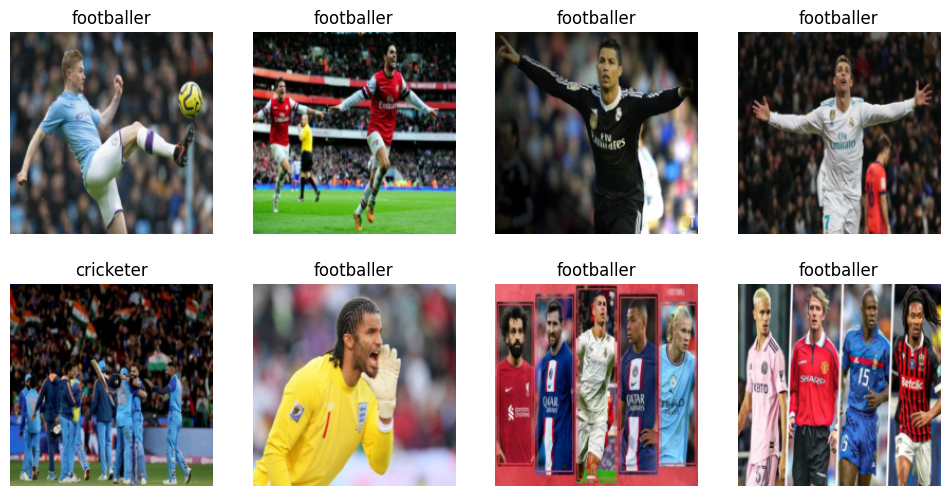

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 205MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.384870,1.416726,0.333333,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.938956,0.800433,0.300000,00:02
1,0.692187,0.590503,0.300000,00:01
2,0.518158,0.536375,0.266667,00:00
3,0.398373,0.469183,0.300000,00:00
4,0.328865,0.412940,0.300000,00:00


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that footballer(Messi) we downloaded at the start:

Probability it's a footballer: 0.8841
This is a: footballer.


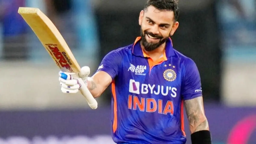

In [13]:
pred,_,probs = learn.predict(PILImage.create('cricketer3.jpg'))
print(f"Probability it's a footballer: {probs[1]:.4f}") # 0 -> cricketer, 1 -> footballer
print(f"This is a: {pred}.")
Image.open('cricketer3.jpg').to_thumb(256, 256)

Good job, resnet34(edited). :)